# Exporting a geotiff file from an analysis workflow

**Notebook currently compatible with the both the `DEA Sandbox` and `NCI` environments**

### Background

Often, at the end of an analysis, we want to export a geotiff **(e.g. outputname.tif)** file, either to save our results, or to allow for exploring our results in a GIS software platform (ArcGIS or QGIS, typically).

### Description

This notebook shows a number of ways to export a geotiff file:
- Exporting a single-band, single time-slice geotiff from an xarray object loaded through a `dc.load` query
- Exporting a multi-band, single time-slice geotiff from an xarray object loaded through a `dc.load` query
- Exporting multiple geotiffs, one for each time-slice of an xarray object loaded through a `dc.load` query
- Exporting a single-band geotiff when handling a simple array and/or an xarray that doesn't contain `transform`, `crs` or `affine` metadata


### Technical details
* **Products used:** [`ga_ls8c_ard_3`](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3/)
* **Analyses used:** `datacube.helpers.write_geotiff` `dea_spatialtools.array_to_geotiff`

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages


In [2]:
%matplotlib inline

import datacube
from datacube.helpers import write_geotiff
import numpy as np
import xarray as xr
import sys

sys.path.append("../Scripts")
import dea_datahandling
from dea_plotting import rgb


### Connect to the datacube

In [3]:
# Temporary solution to account for Collection 3 data being in a different
# database on the NCI
try:
    dc = datacube.Datacube(app='Exporting_geotiffs', env='c3-samples')
except:
    dc = datacube.Datacube(app='Exporting_geotiffs')


## Load Landsat 8 data from the datacube

Here we are loading in a timeseries of `Landsat 8` satellite images through the datacube API.
This will provide us with some data to work with.

In [8]:
# Create a query object
query = {
    'x': (153.40, 153.45),
    'y': (-28.85, -28.90),
    'time': ('2018-01', '2018-03'),
    'measurements': ['nbart_red', 'nbart_green', 'nbart_blue'],
    'output_crs': 'EPSG:3577',
    'resolution': (-30, 30),
    'group_by': 'solar_day'
}

# Load available data from the Landsat 8
ds = dc.load(product='ga_ls8c_ard_3', **query)

# Print output data
print(ds)


<xarray.Dataset>
Dimensions:      (time: 6, x: 191, y: 212)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-03T23:42:39.393181 ... 2018-03-24T23:42:01.382412
  * y            (y) float64 -3.307e+06 -3.307e+06 ... -3.313e+06 -3.313e+06
  * x            (x) float64 2.053e+06 2.053e+06 ... 2.058e+06 2.058e+06
Data variables:
    nbart_red    (time, y, x) int16 411 422 404 396 509 ... 244 285 307 251 247
    nbart_green  (time, y, x) int16 625 640 595 580 697 ... 343 407 470 372 371
    nbart_blue   (time, y, x) int16 435 430 421 412 542 ... 273 308 320 274 270
Attributes:
    crs:      EPSG:3577


### Plot an rgb image to confirm we have data

The white regions are cloud cover.

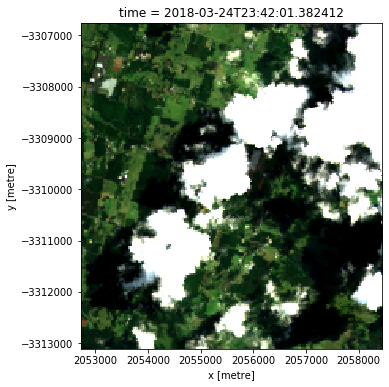

In [9]:
rgb(ds, index=5, percentile_stretch=(0.1, 0.8))


### Export a single-band, single time-slice geotiff

This method uses the `datacube.helpers` function `write_geotiff` to export a simple single-band, single time-slice geotiff. 
An important caveat to using this function is that it requires an `xarray.Dataset`, supplying a `xarray.DataArray` will return an error.

In [10]:
# Select a single time-slice and a single band from the dataset.
# The [['nbart_red']] keeps the array as a `xarray.Dataset`.
singleBandtiff = ds[['nbart_red']].isel(time=1)

# Write geotiff to a location
write_geotiff('red_band.tif', singleBandtiff)

### Export a multi-band, single time-slice geotiff

Here we select a single time and export all the bands in the dataset using the `datacube.helpers.write_geotiff` function.

In [11]:
#select a single time-slice
rgb_tiff = ds.isel(time=1)

#write multi-band geotiff to a location
write_geotiff('rgb.tif', rgb_tiff)


### Export multiple geotiffs, one for each time-slice of an xarray

If we want to export all of the time steps in a dataset as geotiffs, we can wrap our `write_geotiff` function in a for-loop.

In [18]:
for i in range(len(ds.time)):

    # We'll use the date of the satellite image to name the geotiff
    date = str(ds.isel(time=i).time.data)[:-19]
    print(f'Writing {date}')

    # Write geotiff
    write_geotiff(f'{date}.tif', ds.isel(time=i))


Writing 2018-01-03
Writing 2018-01-19
Writing 2018-02-04
Writing 2018-02-20
Writing 2018-03-08
Writing 2018-03-24


### Exporting simple arrays that don't contain geospatial metadata

Often in a workflow we create a numpy array that doesn't have the metadata required to work with functions like `datacube.helpers.write_geotiff`. 
In these instances, we can use the function `dea_datahandling.array_to_geotiff` to export numpy arrays that don't have metadata attached. 

First we will perform some trivial analysis that will require shifting our datacube-acquired xarray object into a numpy array, then we will export our numpy array as a geotiff.
This approach will work on any numpy array as long as we know the projection and the coordinates (which we can get from the original `xarray.Dataset`).

In [8]:
# Convert one of the DataArrays inside the Dataset into a numpy array
arr = ds.nbart_red.isel(time=1).values

# Perform some trivial analysis
simple_array = np.where(arr >= 1, np.nan, 5)

#### Export a single band geotiff

We will use the function `dea_datahandling.array_to_geotiff` to export a simple array:

In [9]:
# First grab the spatial information from our datacube xarray object
transform = ds.geobox.transform.to_gdal()
projection = ds.geobox.crs.wkt

# Export the array
dea_datahandling.array_to_geotiff('simple_array.tif',
                                  simple_array,
                                  geo_transform=transform,
                                  projection=projection,
                                  nodata_val=np.nan)


## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** September 2019

**Compatible `datacube` version:** 

In [10]:
print(datacube.__version__)

1.7+43.gc873f3ea.dirty


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)